## 1. Planing by Dynamic Programming

In [160]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

#H yperparameters
learning_rate = 0.01
epsilon = 0.1

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # 라이브러리들끼리 충돌을 일으켜서 matplotlib plot할 때 커널이 죽는 것을 방지

In [129]:
q_table = np.zeros((19, 50, 5)) # initialize q-value table

In [130]:
def is_state(x, y):
    if y == 0 and (9 <= x <= 18):
        return True
    elif x == 9 and (0 <= y <= 49):
        return True
    elif y == 49 and (0 <= x <= 9):
        return True
    else:
        return False

In [131]:
def is_terminal(x, y):
    if x == 18 and y == 0:
        return True
    elif x == 0 and y == 49:
        return True
    else:
        return False

In [132]:
# 0 : 오른쪽, 1 : 왼쪽, 2 : 아래, 3 : 위, 4 : no-op
dx = [0, 0, 1, -1, 0]
dy = [1, -1, 0, 0, 0]

In [133]:
for repeat in range(0, 10000):
    for x in range(0, 19):
        for y in range(0, 50):
            if is_terminal(x, y) == True:
                continue
            if is_state(x, y) == True:
                # 오른쪽, 왼쪽, 아래, 위, no-op
                for a in [0, 1, 2, 3, 4]:
                    reward = -1
                    if x == 18 and y == 0 and a == 2:
                        reward = 10
                    elif x == 1 and y == 49 and a == 3:
                        reward = 100

                    nxt_state_value = 0
                    nxt_x = x + dx[a]
                    nxt_y = y + dy[a]
                    if is_state(nxt_x, nxt_y) == False:
                        nxt_x, nxt_y = x, y
                    
                    greedy_action = np.argmax(q_table[nxt_x, nxt_y, :])
            
                    for a_ in [0, 1, 2, 3, 4]:
                        probability = 1 - epsilon + (epsilon/5) if a_ == greedy_action else epsilon/5
                        nxt_state_value += (probability*q_table[nxt_x, nxt_y, a_])

                    q_table[x, y, a] = reward + nxt_state_value
         

## 2. Policy Evaluation by DQN

In [134]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, state):
        out = self.forward(state)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,4)
        else: 
            state = list(state.cpu().detach())
            x, y = int(state[0]), int(state[1])
            return np.argmax(q_table[x, y, :])


In [135]:
class Corridor():
    def __init__(self):
        self.x=17
        self.y=0
    
    def step(self, a):
        if a==0:
            self.move_right()
        elif a==1:
            self.move_left()
        elif a==2:
            self.move_down()
        elif a==3:
            self.move_up()
        elif a==4:
            self.no_op()

        reward = -1
        if self.x == 18 and self.y == 0:
            reward = 10
        elif self.x == 0 and self.y == 49:
            reward = 100
            
        done = self.is_done()
        return self.x, self.y, reward, done
    
    def is_state(self):
        if self.y == 0 and (9 <= self.x <= 18):
            return True
        elif self.x == 9 and (0 <= self.y <= 49):
            return True
        elif self.y == 49 and (0 <= self.x <= 9):
            return True
        else:
            return False

    def move_right(self):
        self.y += 1  
        if self.is_state() == False:
            self.y -= 1
      
    def move_left(self):
        self.y -= 1
        if self.is_state() == False:
            self.y += 1
      
    def move_up(self):
        self.x -= 1
        if self.is_state() == False:
            self.x += 1
  
    def move_down(self):
        self.x += 1
        if self.is_state() == False:
            self.x -= 1
            
    def no_op(self):
        pass

    def is_done(self):
        if self.x == 18 and self.y == 0:
            return True
        elif self.x == 0 and self.y == 49:
            return True
        else:
            return False

    def get_state(self):
        return (self.x, self.y)
      
    def reset(self):
        self.x = 17
        self.y = 0
        return (self.x, self.y)

In [136]:
Q = Qnet()

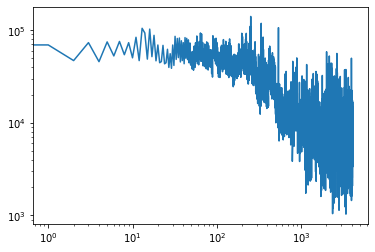

In [161]:
y_val = []
def main():
    global Q
    global y_val
    global epsilon
    env = Corridor()
    q = Qnet()
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    
    
    for n_epi in range(5000):
        x, y = env.reset()
        done = False
        reward = 0
        
        while not done:
            state = torch.tensor([x, y], dtype=torch.float)
            a = q.sample_action(state)
            nxt_x, nxt_y, r, done = env.step(a)
            nxt_state = torch.tensor([nxt_x, nxt_y], dtype=torch.float)
            done_mask = 0.0 if done else 1.0
            
            q_out = q(state)
            q_a = q_out.gather(0, torch.tensor(a))
            
            q_prime_out = q(nxt_state)
            next_greedy_action = np.argmax(q_table[nxt_x, nxt_y, :])
            
            mean_q_prime = 0
            for a_ in [0, 1, 2, 3, 4]:
                probability = 1 - epsilon + (epsilon/5) if a_ == next_greedy_action else epsilon/5
                mean_q_prime += (probability*q_prime_out.gather(0, torch.tensor(a_)))
            
            target = r + mean_q_prime*done_mask
            
            loss = F.mse_loss(q_a, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            x, y = nxt_x, nxt_y

            score += r
            reward += r
            if done:
                break
                
        if n_epi >= 900:
            se = 0
            for row in range(0, 19):
                for col in range(0, 50):
                    if is_state(row, col) == True and is_terminal(row, col) == False:
                        state = torch.tensor([row, col], dtype=torch.float)
                        se += np.sum((q(state).cpu().detach().numpy() - q_table[row, col, :])**2)
            y_val += [se]
    
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(range(900, len(y_val)), y_val, linewidth=1.5)
    Q = q
    
    

if __name__ == '__main__':
    main()

In [162]:
q_table[15, 0, :]

array([28.88861607, 28.88861607, 27.76522789, 29.99999407, 28.88861607])

In [163]:
Q(torch.tensor([15, 0], dtype=torch.float))

tensor([35.5890, 33.3169, 32.3779, 34.9728, 32.6117], grad_fn=<AddBackward0>)